In [11]:
import os, shutil
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
train_dir = '../train'
validation_dir = '../validation'
test_dir = '../test'

In [12]:
from keras.utils import image_dataset_from_directory
IMG_SIZE = 32
train_dataset = image_dataset_from_directory(train_dir,label_mode='categorical',image_size=(IMG_SIZE, IMG_SIZE),batch_size=16)
validation_dataset = image_dataset_from_directory(validation_dir,label_mode='categorical',image_size=(IMG_SIZE, IMG_SIZE),batch_size=16)
test_dataset = image_dataset_from_directory(test_dir,label_mode='categorical',image_size=(IMG_SIZE, IMG_SIZE),batch_size=16)

Found 40000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.


In [13]:
from tensorflow import keras
from keras import layers
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
        layers.RandomContrast(0.2),
        layers.RandomBrightness(0.2),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomHeight(factor=0.2),
        layers.RandomWidth(factor=0.2),
    ]
)

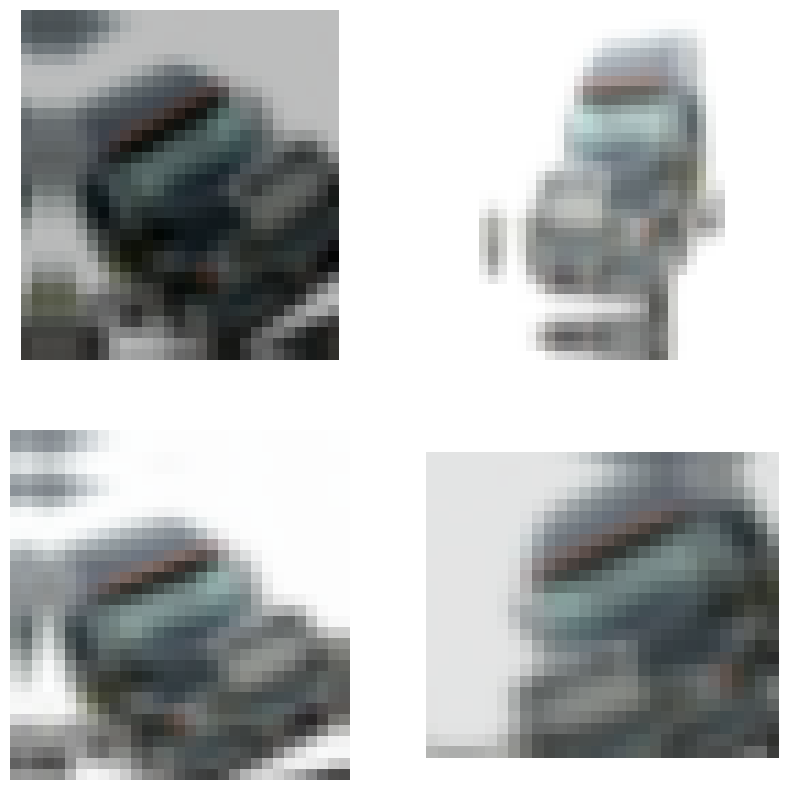

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(4):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

Nesta fase do nosso código tivemos de abdicar da cama densa com L2 devido a um problema de conversão por parte do modelo de h5 para json, impedindo que o nosso modelo fosse, posteriormente, utilizado na nossa aplicação WEB.
Decidimos assim abdicar desta camada.

In [15]:
from tensorflow import keras
from keras import layers
import tensorflow as tf

inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)

x = layers.Rescaling(1./255)(inputs)

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.4)(x)

x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.4)(x)

x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.4)(x)

x = layers.Flatten()(x)
x = layers.Dense(512, activation="relu")(x)
#x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
#x = layers.Dense(64, activation="relu")(x)
#x = layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
#x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(10, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),metrics=['acc'])

In [16]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_4 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 16, 16, 32)        0   

In [17]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)
history = model.fit(train_dataset, epochs=80, validation_data=validation_dataset, callbacks=[early_stopping, reduce_lr])

Epoch 1/80
2500/2500 [==============================] - 43s 17ms/step - loss: 1.8294 - acc: 0.3473 - val_loss: 1.5420 - val_acc: 0.4505 - lr: 0.0010
Epoch 2/80
2500/2500 [==============================] - 53s 21ms/step - loss: 1.5063 - acc: 0.4579 - val_loss: 1.2334 - val_acc: 0.5506 - lr: 0.0010
Epoch 3/80
2500/2500 [==============================] - 54s 21ms/step - loss: 1.3773 - acc: 0.5122 - val_loss: 1.2226 - val_acc: 0.5815 - lr: 0.0010
Epoch 4/80
2500/2500 [==============================] - 51s 20ms/step - loss: 1.2691 - acc: 0.5525 - val_loss: 1.2350 - val_acc: 0.5966 - lr: 0.0010
Epoch 5/80
2500/2500 [==============================] - 52s 21ms/step - loss: 1.1872 - acc: 0.5858 - val_loss: 1.0817 - val_acc: 0.6249 - lr: 0.0010
Epoch 6/80
2500/2500 [==============================] - 52s 21ms/step - loss: 1.1226 - acc: 0.6095 - val_loss: 1.0204 - val_acc: 0.6309 - lr: 0.0010
Epoch 7/80
2500/2500 [==============================] - 50s 20ms/step - loss: 1.0817 - acc: 0.6258 - val_l

In [18]:
val_loss, val_acc = model.evaluate(validation_dataset)
print('val_acc:', val_acc)
model.save('models/projeto_3_data_augmentation.h5')

625/625 [==============================] - 4s 6ms/step - loss: 0.5160 - acc: 0.8261
val_acc: 0.8260999917984009


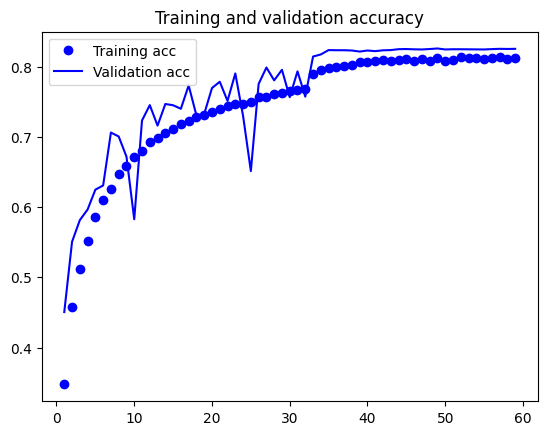

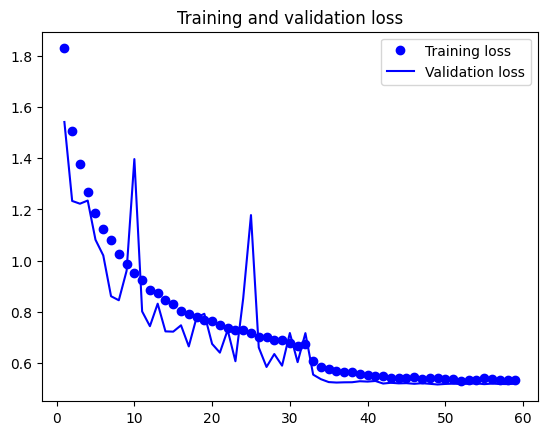

In [19]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

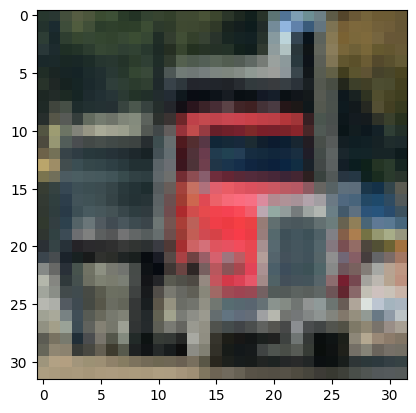

1/1 [==============================] - 0s 70ms/step
Predicted vector: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Actual class: 009_truck ---- Predicted class: Truck
Predicted probabilities: [2.23744623e-09 1.18020966e-04 4.86033852e-11 2.01360074e-11
 7.75222768e-13 3.02065420e-13 5.30916457e-13 8.30654556e-12
 3.19908168e-07 9.99881625e-01]


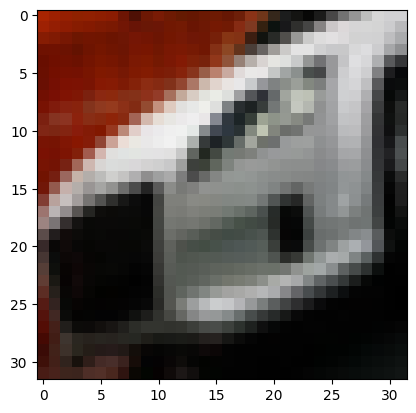

1/1 [==============================] - 0s 10ms/step
Predicted vector: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
Actual class: 001_automobile ---- Predicted class: Automobile
Predicted probabilities: [1.9102162e-02 9.4970977e-01 3.8745676e-03 3.5366649e-04 6.9214752e-06
 5.0883915e-05 2.5839149e-03 8.9312444e-04 2.0562835e-02 2.8621550e-03]


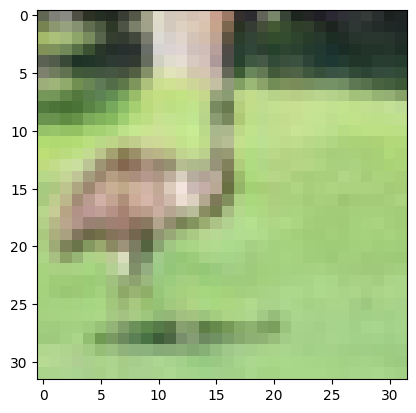

1/1 [==============================] - 0s 10ms/step
Predicted vector: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
Actual class: 002_bird ---- Predicted class: Deer
Predicted probabilities: [4.0081606e-04 2.5968086e-06 3.1129926e-01 9.1344062e-03 6.2014937e-01
 9.7896429e-03 2.2723593e-02 2.6475821e-02 1.0589267e-05 1.3848095e-05]


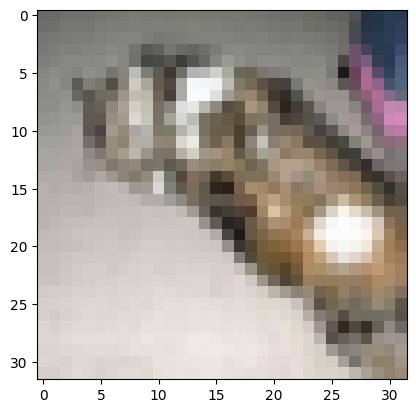

1/1 [==============================] - 0s 10ms/step
Predicted vector: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
Actual class: 003_cat ---- Predicted class: Cat
Predicted probabilities: [0.0059674  0.00055162 0.06290957 0.4199306  0.05325221 0.317974
 0.13334045 0.00348923 0.00122338 0.00136149]


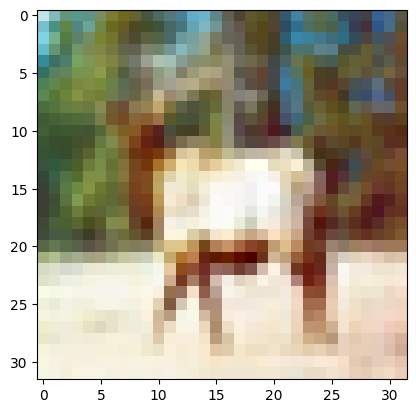

1/1 [==============================] - 0s 10ms/step
Predicted vector: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
Actual class: 004_deer ---- Predicted class: Deer
Predicted probabilities: [2.2561576e-08 2.7589953e-10 1.5421938e-05 2.5961173e-05 8.7876803e-01
 6.4661284e-04 8.6278823e-07 1.2054315e-01 1.1463889e-09 1.9903952e-08]


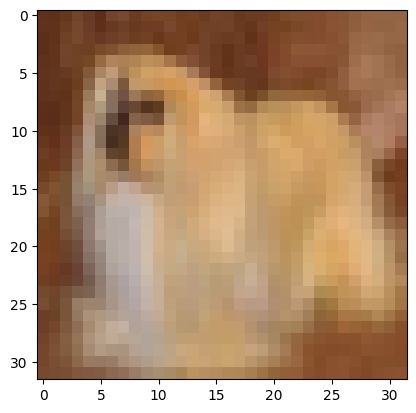

1/1 [==============================] - 0s 10ms/step
Predicted vector: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
Actual class: 005_dog ---- Predicted class: Dog
Predicted probabilities: [4.7145048e-09 2.3958355e-12 1.5426443e-06 7.6218373e-03 2.5280779e-06
 9.9235302e-01 1.6578583e-07 2.0969150e-05 8.0034562e-10 5.5230958e-09]


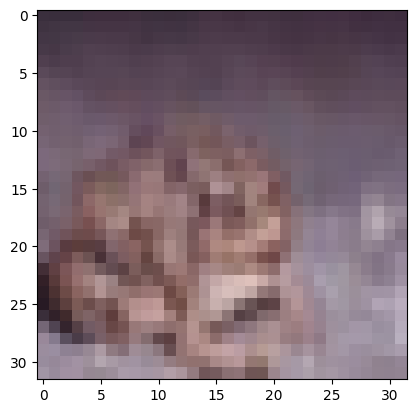

1/1 [==============================] - 0s 10ms/step
Predicted vector: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
Actual class: 006_frog ---- Predicted class: Frog
Predicted probabilities: [9.3331863e-08 3.1390166e-09 5.0701263e-05 4.0398622e-03 1.5741787e-05
 1.9896410e-05 9.9582303e-01 1.7424178e-08 5.0618259e-05 3.5045343e-08]


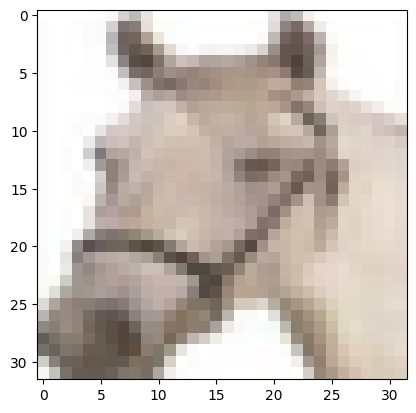

1/1 [==============================] - 0s 25ms/step
Predicted vector: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
Actual class: 007_horse ---- Predicted class: Horse
Predicted probabilities: [4.30474207e-02 1.67831167e-04 4.90849167e-02 4.97415811e-02
 5.16755283e-02 1.43653713e-02 1.09834215e-02 7.77714550e-01
 4.07452229e-04 2.81193526e-03]


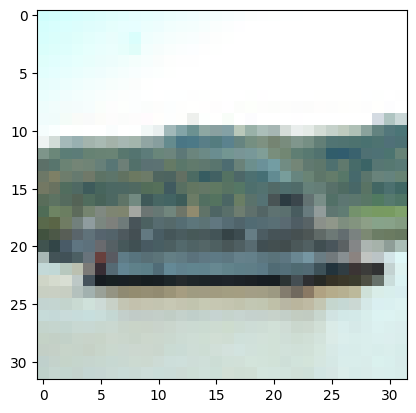

1/1 [==============================] - 0s 10ms/step
Predicted vector: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
Actual class: 008_ship ---- Predicted class: Ship
Predicted probabilities: [1.3350226e-06 5.3627014e-07 3.3041698e-11 8.3102514e-10 8.5304680e-12
 9.4464604e-15 2.2160352e-11 3.5435938e-14 9.9999654e-01 1.4994209e-06]


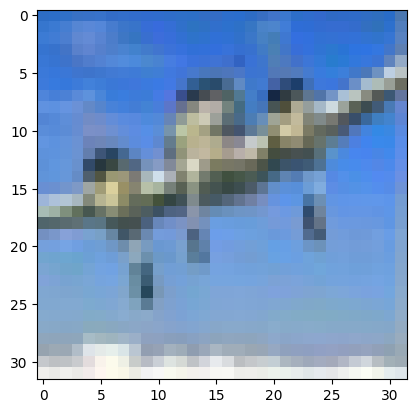

1/1 [==============================] - 0s 10ms/step
Predicted vector: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Actual class: 000_airplane ---- Predicted class: Airplane
Predicted probabilities: [9.9903131e-01 3.3021443e-08 9.5844222e-04 9.3558647e-08 2.9208265e-06
 1.5415726e-09 1.0800886e-06 2.6249170e-08 5.7072589e-06 3.6386118e-07]


In [20]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
from tensorflow import keras
import os

# Carrega o modelo salvo
model = keras.models.load_model('models/projeto_3_data_augmentation.h5')

# Função para prever a classe de uma imagem
def predict_image_class(label):
    # Diretório das imagens de treino
    img_dir = f'../train/{label}'
    
    # Lista de arquivos de imagem no diretório
    image_files = [f for f in os.listdir(img_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    
    # Seleciona uma imagem aleatória da lista
    random_image = random.choice(image_files)
    img_path = os.path.join(img_dir, random_image)
    
    # Carrega e exibe a imagem
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    plt.imshow(img)
    plt.show()
    
    # Prepara a imagem para a predição
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    
    # Realiza a predição
    predictions = model.predict(img_array)

    # Vetor de probabilidades estatísticas
    predicted_probabilities = predictions[0]
    
    # Determina a classe prevista
    predicted_class_index = np.argmax(predictions)
    
    # Vetor de predição
    predicted_vector = np.zeros_like(predictions)
    predicted_vector[0, predicted_class_index] = 1
    
    # Mapeamento de índices de classes para rótulos
    class_labels = {
        0: "Airplane",
        1: "Automobile",
        2: "Bird",
        3: "Cat",
        4: "Deer",
        5: "Dog",
        6: "Frog",
        7: "Horse",
        8: "Ship",
        9: "Truck"
    }
    
    # Obtém o rótulo da classe prevista
    predicted_label = class_labels[predicted_class_index]
    
    # Exibe os resultados
    print(f"Predicted vector: {predicted_vector}")
    print(f"Actual class: {label} ---- Predicted class: {predicted_label}")
    print(f"Predicted probabilities: {predicted_probabilities}")


# Lista de rótulos para prever
labels = ['009_truck', '001_automobile', '002_bird', '003_cat', '004_deer', '005_dog', '006_frog', '007_horse', '008_ship', '000_airplane']

# Realiza predições para cada rótulo na lista
for label in labels:
    predict_image_class(label)